## 深度卷积神经网络-AlexNet
**机器学习-核方法**  
特征提取  
选择核函数来计算相关性-通过变换空间，将空间拉成想要的样子  
凸优化问题  
漂亮的定理  

SVM对调参不敏感  

**几何学**  
抽取特征  
描述几何（例如多相机）  
（非）凸优化  
漂亮定理  
如果假设（物理模型）满足了，效果很好  

**特征工程**--对图片如何抽取特征-关键  
特征描述子：SIFT、SURF  
视觉词袋（聚类）  
最后用SVM  

**数据**和**硬件**不同阶段的发展程度导致对**网络**选取的偏好

ImageNet  
自然物体的彩色图片  
更大的数据集允许使用更深的神经网络抽取其中更复杂的信息  

![AlexNet.png](动手学深度学习_图片\AlexNet.png)

- CNN构造简单，不需要了解太多计算机视觉的专业知识，容易跨不同的问题  
- 分类器和特征提取模型是一起训练的  
  CNN学出来的东西很有可能就是softmax想要的  
  
端到端-原始的数据到最终的分类/预测  

**AlexNet**
图片3通道  
更大的核窗口和步幅，因为图片更大了；更多的输出通道，因为有更多信息  
更大的池化窗口，最大池化层  
新加了3层卷积层  
增大隐藏层大小，最后是1000类输出  
ReLu激活函数  
隐藏全连接层后加入丢弃层，减轻过拟合  
数据增强（随机截取、亮度、色温），同时不容易记住数据  

AlexNet是更大更深的LeNet，10x参数个数，260x计算复杂度

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

net = nn.Sequential(
    nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),  # 由于使用Fashion-MNIST，输入通道数为1
    nn.MaxPool2d(kernel_size=3, stride=2),
    # 减小卷积窗口，使用填充为2来使得输入与输出的高和宽一致
    nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),
    nn.Linear(6400, 4096), nn.ReLU(), nn.Dropout(p=0.5),
    nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(p=0.5),
    # 由于使用Fashion-MNIST，输出层类别数为10
    nn.Linear(4096, 10))


In [ ]:
# 构造一个单通道数据，观察每一层输出的形状
X = torch.randn(1, 1, 224, 224)
for layer in net:
    X=layer(X)
    print(layer.__class__.__name__,'output shape:\t',X.shape)

In [ ]:
# Fashion-MNIST图像的分辨率低于ImageNet图像，把它们增加到224x224（实际情况下不会这么做）
batch_size = 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)

In [ ]:
lr, num_epochs = 0.01, 10
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())
# 并行度，GPU使用率。虽然计算量多了200+倍，但实际上仅慢了20倍

QA

## 使用块的网络-VGG
AlexNet-长得不规则，很随意，结构不清晰  
模型要变深变大需要**更好的设计思想**

更好得更深更大：  
- 更多的全连接层（太贵）  
- 更多的卷积层  
- 将卷积层组合成块

VGG块  
3x3卷积（填充1）（n层，m通道）  
2x2最大池化层（步幅2）  
为什么不用5x5：计算量更大，模型会更浅。在同样计算开销情况下，**窄但深效果更好**

VGG架构  
多个VGG块后接全连接层  
不同次数的**重复块**得到不同的架构

更大更深的AlexNet

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

# VGG块
def vgg_block(num_convs, in_channels, out_channels):  # 卷积层个数，输入通道数，输出通道数
    layers = []
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU())
        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

In [ ]:
# VGG网络

# 架构
# 5块，每一块高宽减半（MaxPooling），通道数翻倍。224除以5次2等于7，质数
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))  # 卷积层数，通道数

def vgg(conv_arch):
    conv_blks = []
    in_channels = 1
    # 卷积层部分
    for (num_convs, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels

    return nn.Sequential(
        *conv_blks, nn.Flatten(),
        # 全连接层部分
        nn.Linear(out_channels * 7 * 7, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 10))

net = vgg(conv_arch)

In [ ]:
X = torch.randn(size=(1, 1, 224, 224))
for blk in net:
    X = blk(X)
    print(blk.__class__.__name__,'output shape:\t',X.shape)

In [ ]:
# 由于VGG-11比AlexNet计算量更大，因此我们构建了一个通道数较少的网络
ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]  # 通道数除以4，计算量减少16倍
net = vgg(small_conv_arch)

In [ ]:
lr, num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())
# VGG很贵

QA

## 网络中的网络-NiN
全连接层参数多（内存、计算带宽），占比大，容易过拟合
- 卷积层：输入通道数 * 输出通道数 * k*k（卷积核窗口大小）
- 卷积层后第一个全连接层：通道数 * 图片大小 * 输出大小

NiN块
一个卷积层后跟两个全连接层（**1x1卷积**）
- 步幅1，无填充，输出形状跟卷积层输出一样
- 起到全连接层的作用（wi相同）
- 对每个像素增加了非线性性

NiN架构  
**无全连接层**  
交替使用NiN块和步幅为2的最大池化层
- 逐步减小高宽和增大通道数
最后使用全局平均池化层得到输出
- 池化层的高宽等于输入的高宽，对每一个通道拿一个值，作为对类别的预测，再softmax
- 输入通道数是类别数
- 不容易过拟合，参数个数更少

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l    


def nin_block(in_channels, out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding), nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU(),  # 不改变通道数
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU())

# NiN由AlexNet来
net = nn.Sequential(
    nin_block(1, 96, kernel_size=11, strides=4, padding=0),  # 灰度图
    nn.MaxPool2d(3, stride=2),
    nin_block(96, 256, kernel_size=5, strides=1, padding=2),
    nn.MaxPool2d(3, stride=2),
    nin_block(256, 384, kernel_size=3, strides=1, padding=1),
    nn.MaxPool2d(3, stride=2),
    nn.Dropout(0.5),
    # 标签类别数是10
    nin_block(384, 10, kernel_size=3, strides=1, padding=1),
    nn.AdaptiveAvgPool2d((1, 1)),  # 高宽都变成1
    # 将四维的输出转成二维的输出，其形状为(批量大小,10)
    nn.Flatten())

In [ ]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

In [ ]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

QA

## 含并行连结的网络 GoogLeNet / Inception V3
第一个超过100层（卷积层个数）的卷积神经网络  
受NiN影响

Inception块：
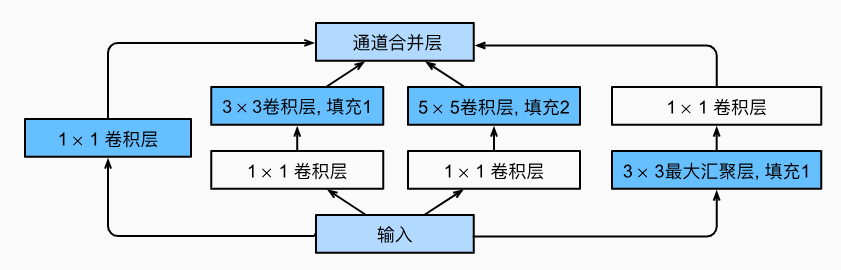

4个路径从不同层面抽取信息，在输出通道维合并  
输出跟输入等同高宽  
通道数改变  
- 白色1x1卷积可以认为用来变换通道数
- 蓝色用来抽取信息（空间信息、通道信息）

通过降低通道数来控制模型复杂度  
每条路上通道数可以不同  
- 哪个路径重要，通道数多
Inception块与单3x3或5x5卷积层比，有更少的参数个数和计算复杂度（通道数不变）

GoogLeNet  
5段，9个Inception块  
段1&段2：通道数增多，高宽减小  
段3：2个Inception块，输出通道增加，图片变小  
通道分配不同  
段4&段5：通道数增多，高宽减小

Inception-V3：修改了Inception块
- 替换5x5为多个3x3
- 替换3x3、5x5为1x7和7x1（多个）
- 替换3x3为1x3和3x1（并行）
- 更深

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

# Inception块
class Inception(nn.Module):
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):  # c1-c4是每条路径的通道数
        super(Inception, self).__init__(**kwargs)
        # 线路1，单1x1卷积层
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        # 线路2，1x1卷积层后接3x3卷积层
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        # 线路3，1x1卷积层后接5x5卷积层
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        # 线路4，3x3最大汇聚层后接1x1卷积层
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)

    def forward(self, x):
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(self.p4_1(x)))
        # 在通道维度上连结输出
        return torch.cat((p1, p2, p3, p4), dim=1)

In [ ]:
# 每一个stage
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1),
                   nn.ReLU(),
                   nn.Conv2d(64, 192, kernel_size=3, padding=1),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b3 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32),
                   Inception(256, 128, (128, 192), (32, 96), 64),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                   Inception(512, 160, (112, 224), (24, 64), 64),
                   Inception(512, 128, (128, 256), (24, 64), 64),
                   Inception(512, 112, (144, 288), (32, 64), 64),
                   Inception(528, 256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                   Inception(832, 384, (192, 384), (48, 128), 128),
                   nn.AdaptiveAvgPool2d((1,1)),
                   nn.Flatten())

net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))

In [ ]:
# 为了使Fashion-MNIST上的训练短小精悍，将输入的高和宽设为96
X = torch.rand(size=(1, 1, 96, 96))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

In [ ]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

QA

## 批量归一化
几乎所有卷积神经网络都用

算backward时，从上往下，梯度在上面比较大，越往下越容易变小  
损失出现在最后  
- 后面的层训练较快
数据在最底部  
- 底部的层训练较慢
- 底部层一变，所有都得跟着变（底层信息变，上面的权重就白学了），最后的那些层需要重新学习多次，导致**收敛变慢**

在学习底部层的时候避免变化顶部层

固定小批量里面的均值和方差，然后再做额外调整（可学习的参数）
- 若每一层的输出和梯度都大致符合某一个分布，就相对稳定

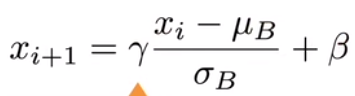

xi：输入  
μB：均值（从数据中来）  
σB：方差（从数据中来）  
γ：方差（可学习参数）  
β：均值（可学习参数）  
会限制γ和β不要变化过于猛烈

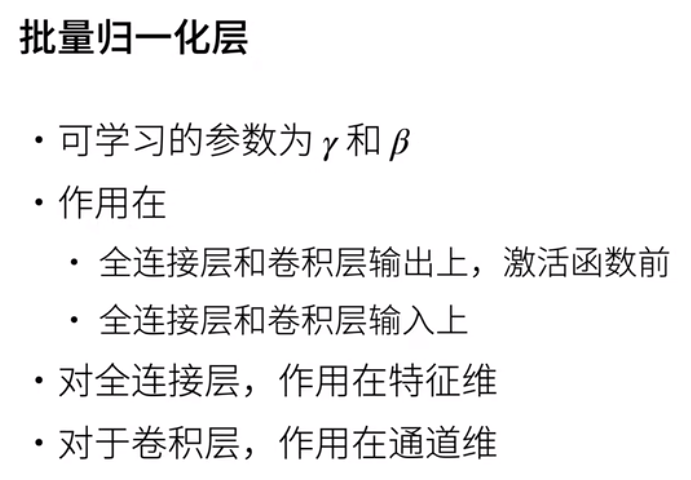

批量归一化是一个线性变换，激活函数加入非线性

有论文指出它可能就是通过在每个小批量里加入噪音来控制模型复杂度
- μB和σB是噪音，因为是在每一个**随机**的小批量上计算而来，是随机值，相当于随机偏移和随机缩放
- γ和β缓慢变化，比较**稳定**
因此没必要跟丢弃法混合使用

可以加速收敛速度，学习率可以调大，但一般不改变模型精度

In [ ]:
## 从零开始实现
import torch
from torch import nn
from d2l import torch as d2l

def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum): # moving_mean全局均值，moving_var全局方差，eps避免除零，momentum用来更新moving_mean和moving_var
    # 通过is_grad_enabled判断当前模式是训练模式还是预测模式
    if not torch.is_grad_enabled():
        # 在预测模式下，直接使用传入的全局均值和方差
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:  # (批量大小，特征) 
            # 全连接层，计算特征维上的均值和方差
            mean = X.mean(dim=0)  # 按行求均值，行向量
            var = ((X - mean) ** 2).mean(dim=0)
        else:  # (批量大小，通道数，高，宽)
            # 二维卷积层，计算通道维上（axis=1）的均值和方差。
            # 这里需要保持X的形状以便后面可以做广播运算
            mean = X.mean(dim=(0, 2, 3), keepdim=True)  # (1,n,1,1)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        # 训练模式下，用当前的均值和方差做标准化
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # 更新
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta
    return Y, moving_mean.data, moving_var.data

In [ ]:
# BatchNorm层
class BatchNorm(nn.Module):
    # num_features：全连接层的输出数量或卷积层的输出通道数。
    # num_dims：2表示全连接层，4表示卷积层
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # 参与求梯度和迭代，分别初始化成1和0
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # 非模型参数的变量，不需迭代，初始化为0和1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        # 如果X不在内存上，将moving_mean和moving_var复制到X所在显存上
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        Y, self.moving_mean, self.moving_var = batch_norm(X, self.gamma, self.beta, self.moving_mean,
                                                          self.moving_var, eps=1e-5, momentum=0.9)
        return Y

In [ ]:
# 应用BatchNorm于LeNet模型
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), BatchNorm(16, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), 
    nn.Flatten(),
    nn.Linear(16*4*4, 120), BatchNorm(120, num_dims=2), nn.Sigmoid(),
    nn.Linear(120, 84), BatchNorm(84, num_dims=2), nn.Sigmoid(),
    nn.Linear(84, 10))

In [ ]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [ ]:
# 从第一个BatchNorm层中学到的拉伸参数gamma和偏移参数beta
net[1].gamma.reshape((-1,)), net[1].beta.reshape((-1,))

In [ ]:
## 简明实现
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), nn.BatchNorm2d(6), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), 
    nn.Flatten(),
    nn.Linear(256, 120), nn.BatchNorm1d(120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.BatchNorm1d(84), nn.Sigmoid(),
    nn.Linear(84, 10))

d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

QA

## 残差网络-ResNet
加深不一定总是改进精度  
模型虽然复杂了，但有可能**学偏**了，还不如小模型的最优解近--模型偏差

加更多的层，结果永远不会变差

残差块  
串联一个层会改变函数类，我们希望能扩大函数类  
残差块加入快速通道来得到**f(x)=x+g(x)**结构

可以试各种不同的组合

ResNet块  
高宽减半ResNet块（3x3、BN、ReLu）（步幅2）（加法部分可通过1x1改变通道数）  
后接多个高宽不变ResNet块

ResNet架构  
类似VGG和GoogLeNet，替换成了ResNet块

残差块使得**很深的网络**更加容易训练，甚至可以训练1000层的网络  
残差网络对随后的深层神经网络设计产生了深远影响，无论是卷积类网络还是全连接类网络


In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

# 残差块
class Residual(nn.Module):  #@save
    def __init__(self, input_channels, num_channels, use_1x1conv=False, strides=1):
        # 输入通道数，输出通道数，是否用1x1卷积层，步幅
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
        self.relu = nn.ReLU(inplace=True)  # 省点内存

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [ ]:
# 输入和输出形状一致
blk = Residual(3,3)
X = torch.rand(4, 3, 6, 6)
Y = blk(X)
Y.shape

# 增加输出通道数的同时，减半输出的高和宽
blk = Residual(3,6, use_1x1conv=True, strides=2)
blk(X).shape

In [ ]:
# ResNet模型
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

# stage
def resnet_block(input_channels, num_channels, num_residuals, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels,
                                use_1x1conv=True, strides=2))  # 高宽减半
        else:
            blk.append(Residual(num_channels, num_channels))  # 通道数不变
    return blk

b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), 
                    nn.Linear(512, 10))

In [ ]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

In [ ]:
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())
# 过拟合

QA